# Introduction

Hello everyone! This is my second Kaggle Notebook. In this one I will discuss how I approached the House Price Prediction challenge and analyzed this dataset. So first, let's us load the data and import all the libraries we will use.

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


The below method calculated the root mean squared log error that the submission score will be calculated based on. Since it is not a standard score metric in sklearn, we will write this one by ourselves. 

In [2]:
def root_mean_squared_log_error(y_valid, y_preds):
    """Calculate root mean squared error of log(y_true) and log(y_pred)"""
    if len(y_preds)!=len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new, y_preds_new, squared=False)

# Take a look at our training set

I always believe before we do any data analysis, we should take a look at our data.

In [3]:
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
pd.set_option('display.max_columns', None)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_data.shape

(1460, 81)

In [5]:
print(train_data.columns[train_data.isna().any()].unique())
len(train_data.columns[train_data.isna().any()].unique())

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


19

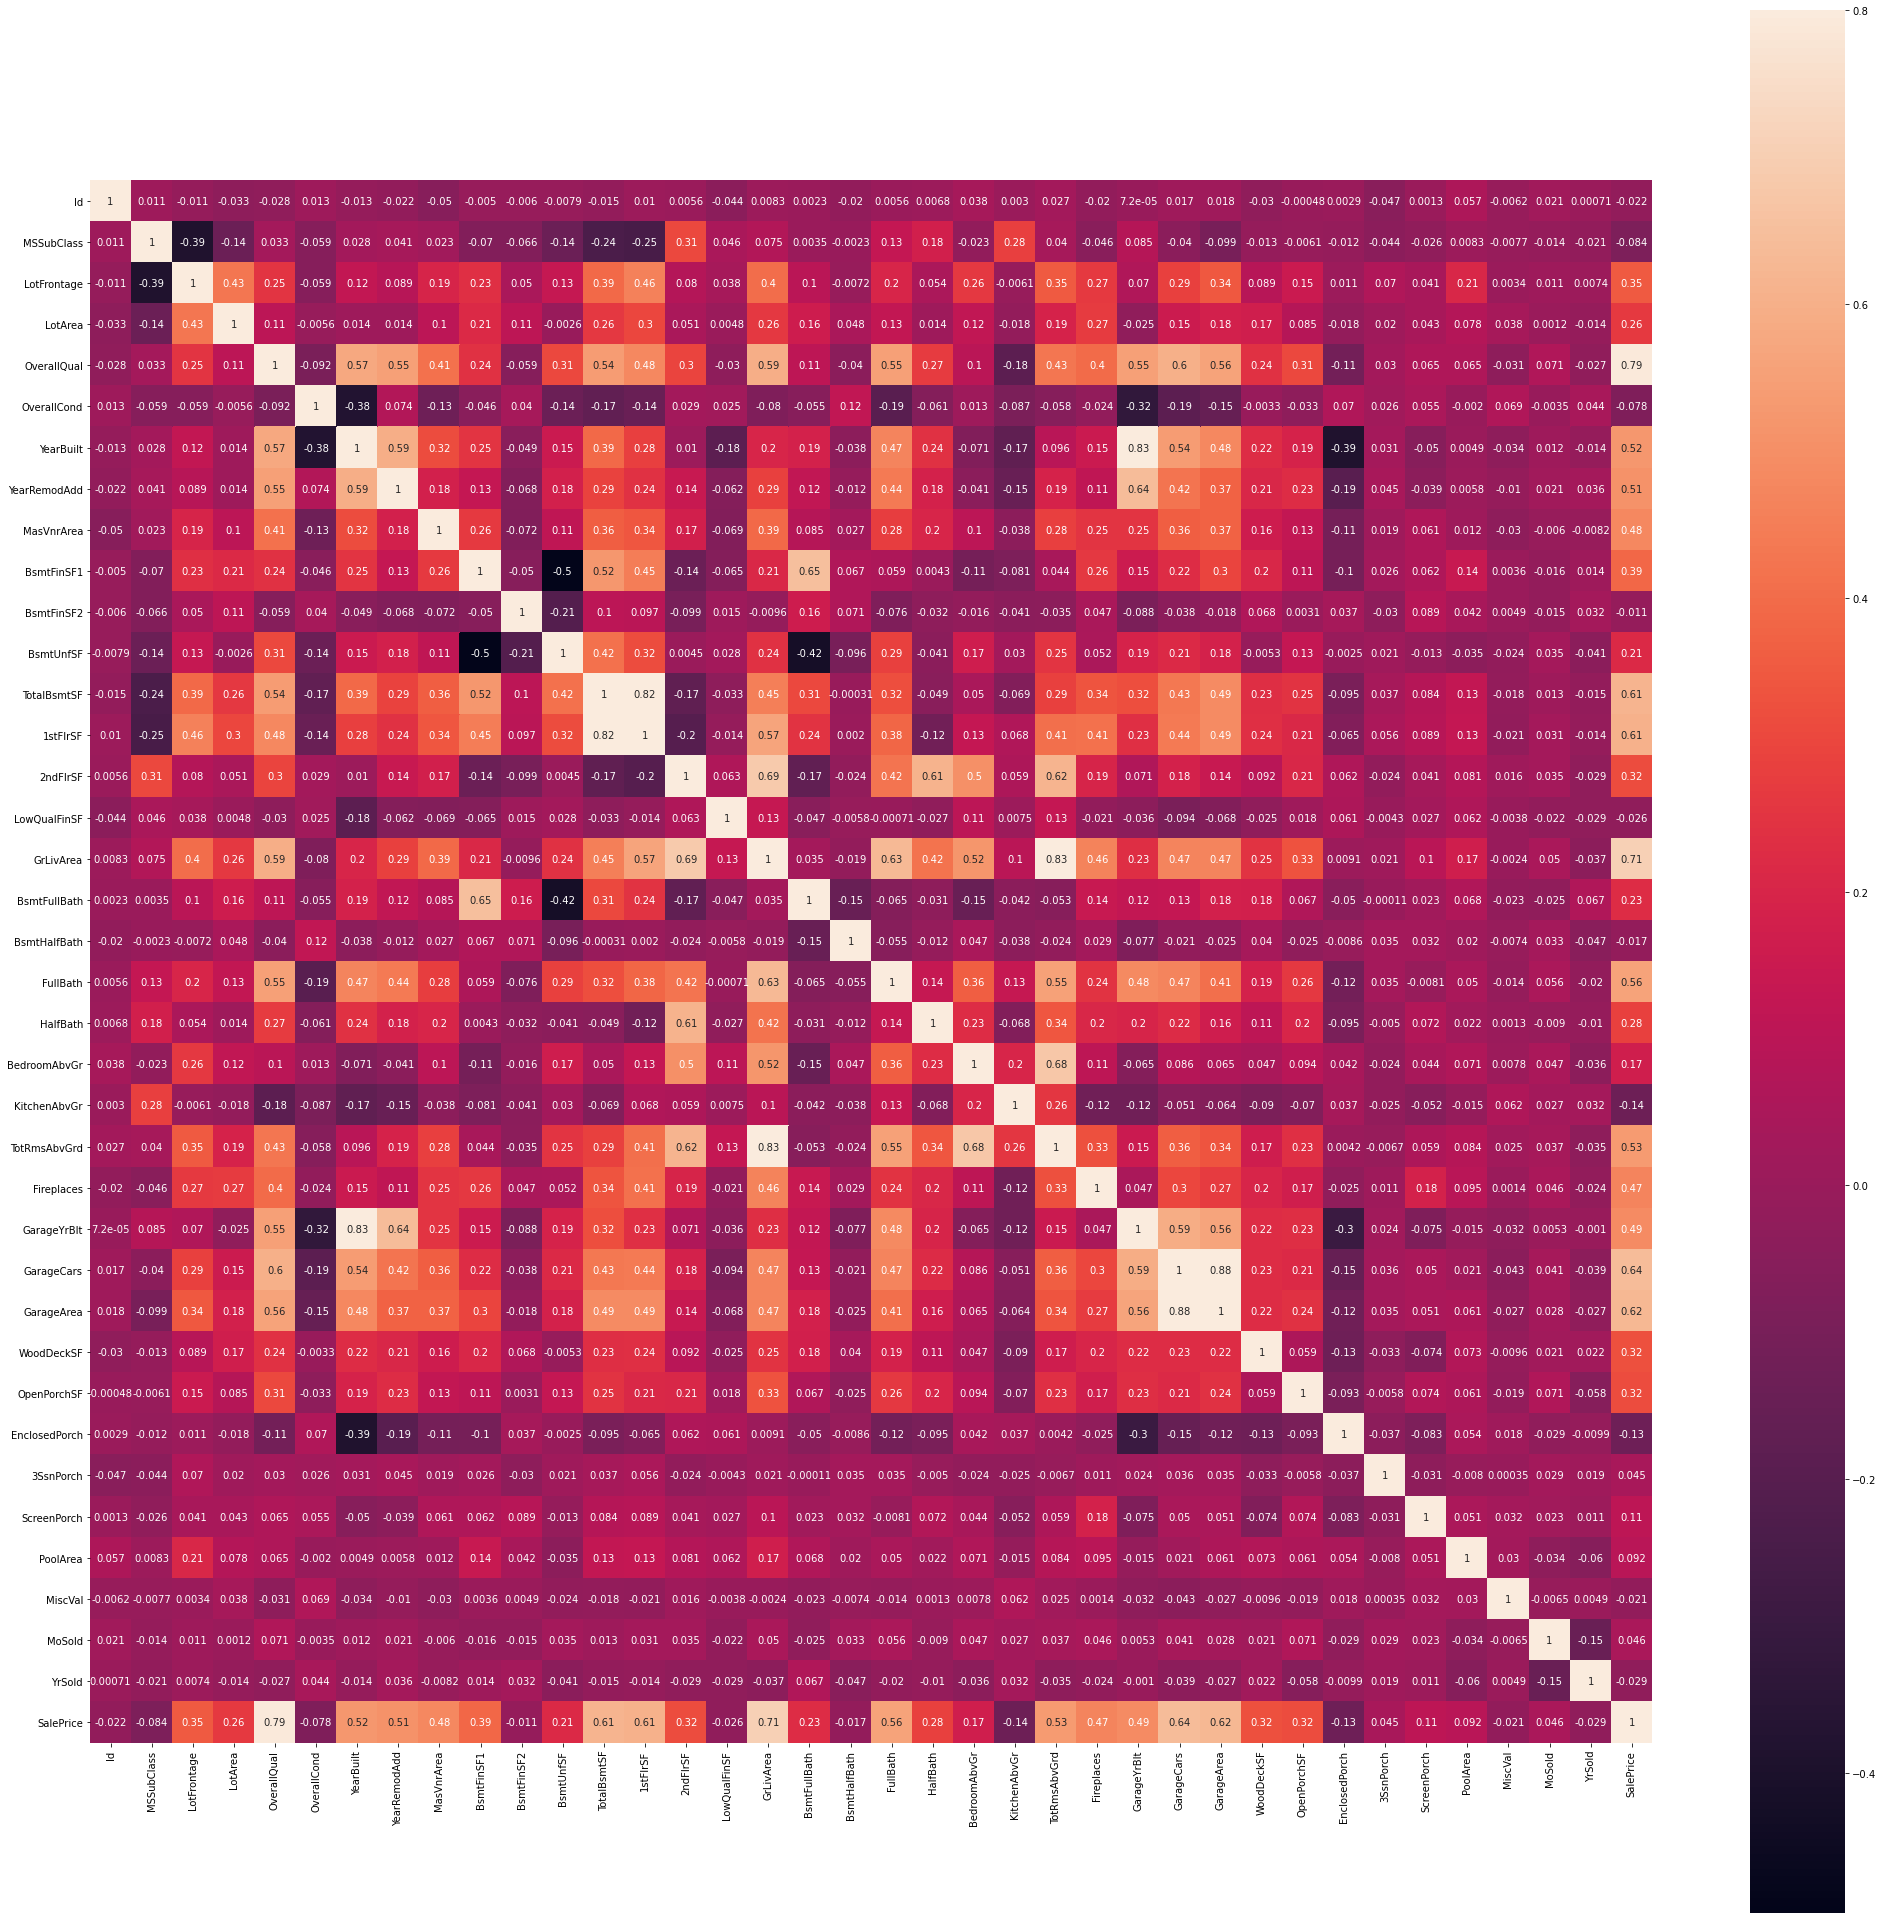

In [6]:
#correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(35, 35))
sns.heatmap(corrmat, annot=True, vmax=.8, square=True);

From the above codes, we can see that our train data has 1460 entries with 81 variables. Also, 19 of these variables contain missing values, and the exact columns that have missing values are also outputed using train_data.columns[train_data.isna().any()].unique(). 

Then, the heatmap tells us the correlations between different variables. Heatmap with the correlation matrix is honestly a very powerful way for us to quickly understand the relationship between data. If we look at the SalePrice row, we can clearly see that it is highly correlated with variables like OverallQual, GriLivArea, and etc. These are also useful information we should take into consideration. 

# Model Selection

Before we explore further, let's just select the model we are going to use. In this section, we will make some quick implementations of different machine learning models and choose one with the best performance. The models will simply be trained using all features except SalePrice column and be scored using root mean squared log error. 

In [7]:
features = [x for x in train_data.columns if x not in ['SalePrice']]
X = train_data.drop(['SalePrice'], axis=1)
Y = train_data['SalePrice']

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, random_state=42)

numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 13 and 
                    X_train[cname].dtype == "object"]


numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

In [9]:
from sklearn.ensemble import RandomForestRegressor

random_model = RandomForestRegressor(random_state=42, n_estimators=1000)

random_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('random_model', random_model)
                     ])

random_clf.fit(X_train, y_train)

random_clf.fit(X_train, y_train)

random_preds = random_clf.predict(X_valid)

print('RMSLE:', root_mean_squared_log_error(y_valid, random_preds))

RMSLE: 0.1437615617331464


In [10]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)

xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb_model', xgb_model)
                     ])

xgb_clf.fit(X_train, y_train, xgb_model__verbose=False)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_valid)

print('RMSLE:', root_mean_squared_log_error(y_valid, xgb_preds))

RMSLE: 0.13666707029863676


In [11]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor(random_state=42, learning_rate=0.01, n_estimators=1000)

ada_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb_model', ada_model)
                     ])

ada_clf.fit(X_train, y_train)

ada_clf.fit(X_train, y_train)

ada_preds = ada_clf.predict(X_valid)

print('RMSLE:', root_mean_squared_log_error(y_valid, ada_preds))

RMSLE: 0.20429289581404445


Since XGB Regressor has the best performance, we will use this model in later sections.

# Feature Engineering 

So now we have decided on which model to use. Let's determine the parameters we want to feed to our model. So from the correlation matrix, we can see that OverallQual, OverallCond, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, GarageCars, and GarageArea are parameters that are highly correlated(>0.5) with the SalePrice variable.

Let's see the distributions of these variables.

**OverallQual**

In [12]:
train_data['OverallQual'].isnull().sum()

0

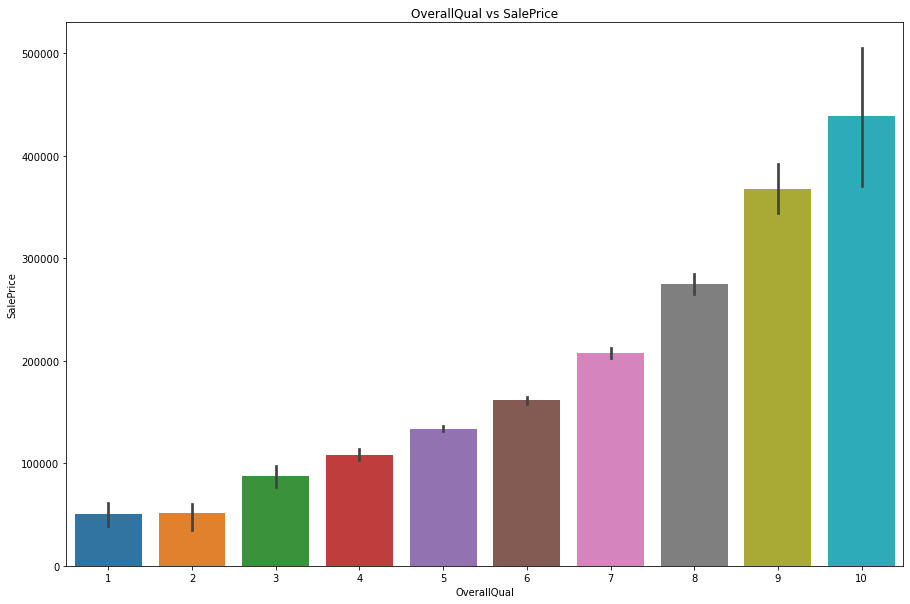

In [13]:
plt.figure(figsize=(15, 10))
plt.title("OverallQual vs SalePrice")
sns.barplot(x='OverallQual', y='SalePrice', data=train_data)
plt.show()

**OverallCond**

In [14]:
train_data['OverallCond'].isnull().sum()

0

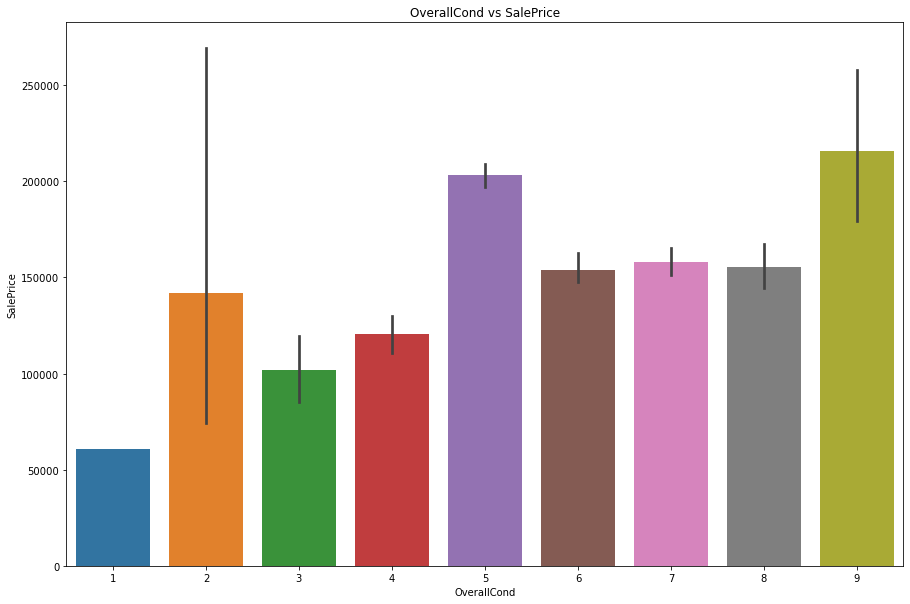

In [15]:
plt.figure(figsize=(15, 10))
plt.title("OverallCond vs SalePrice")
sns.barplot(x='OverallCond', y='SalePrice', data=train_data)
plt.show()

**YearBuilt**

In [16]:
train_data['YearBuilt'].isnull().sum()

0

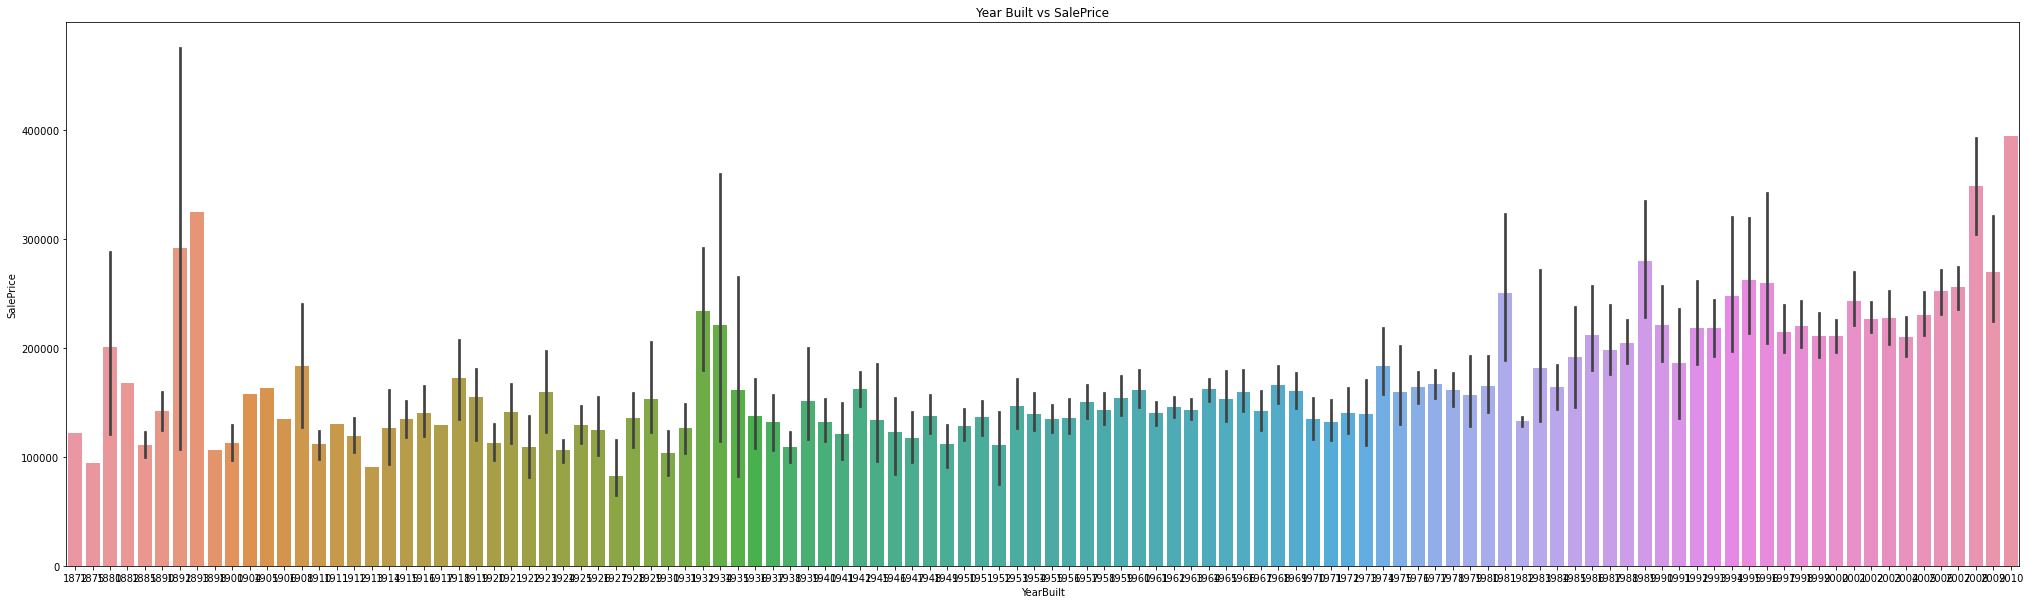

In [17]:
plt.figure(figsize=(35, 10))
plt.title("Year Built vs SalePrice")
sns.barplot(x='YearBuilt', y='SalePrice', data=train_data)
plt.show()

**YearRemodAdd**

In [18]:
train_data['YearRemodAdd'].isnull().sum()

0

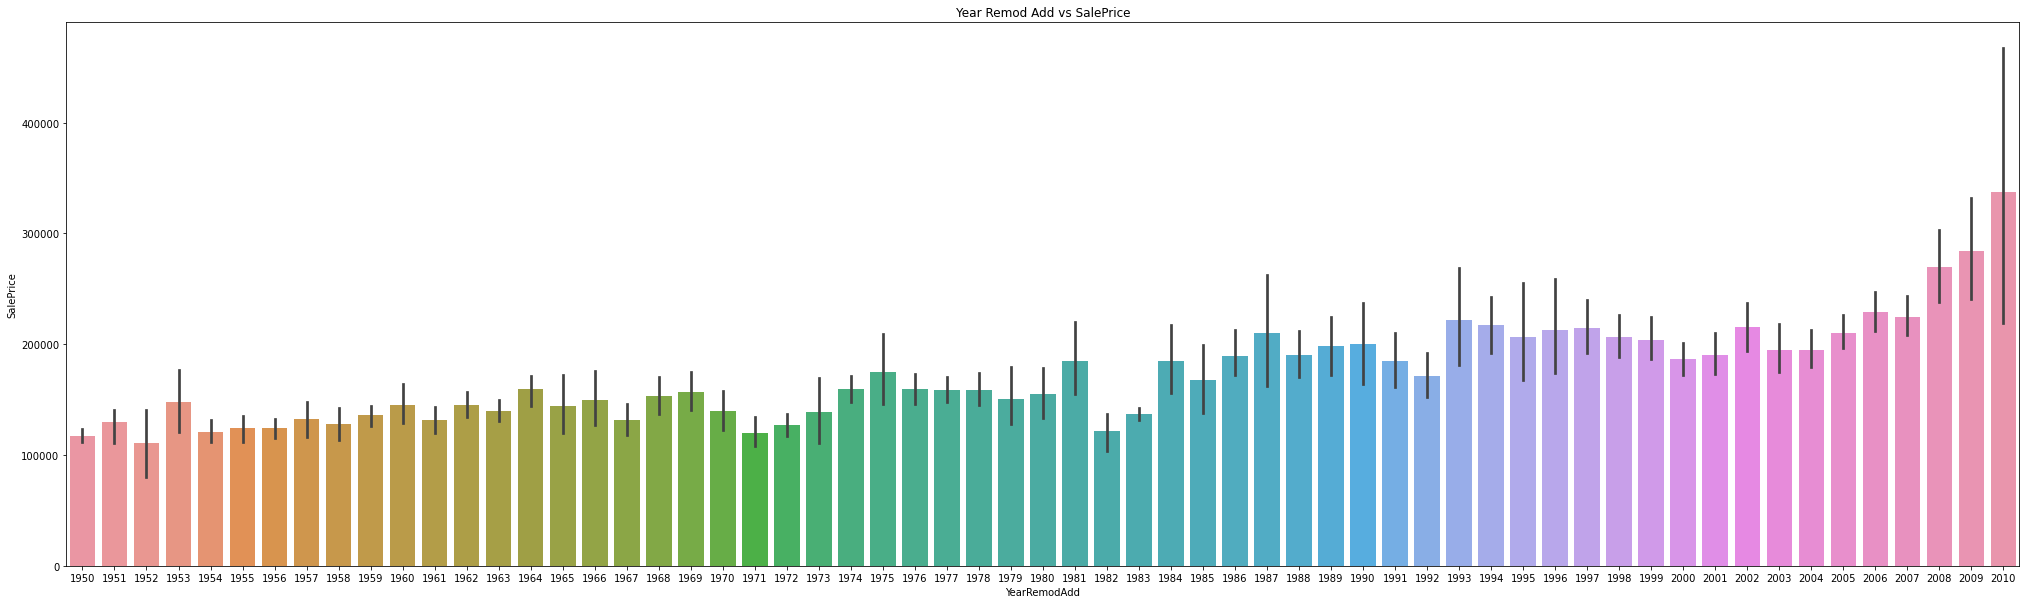

In [19]:
plt.figure(figsize=(35, 10))
plt.title("Year Remod Add vs SalePrice")
sns.barplot(x='YearRemodAdd', y='SalePrice', data=train_data)
plt.show()

**TotalBsmtSF**

In [20]:
train_data['TotalBsmtSF'].isnull().sum()

0

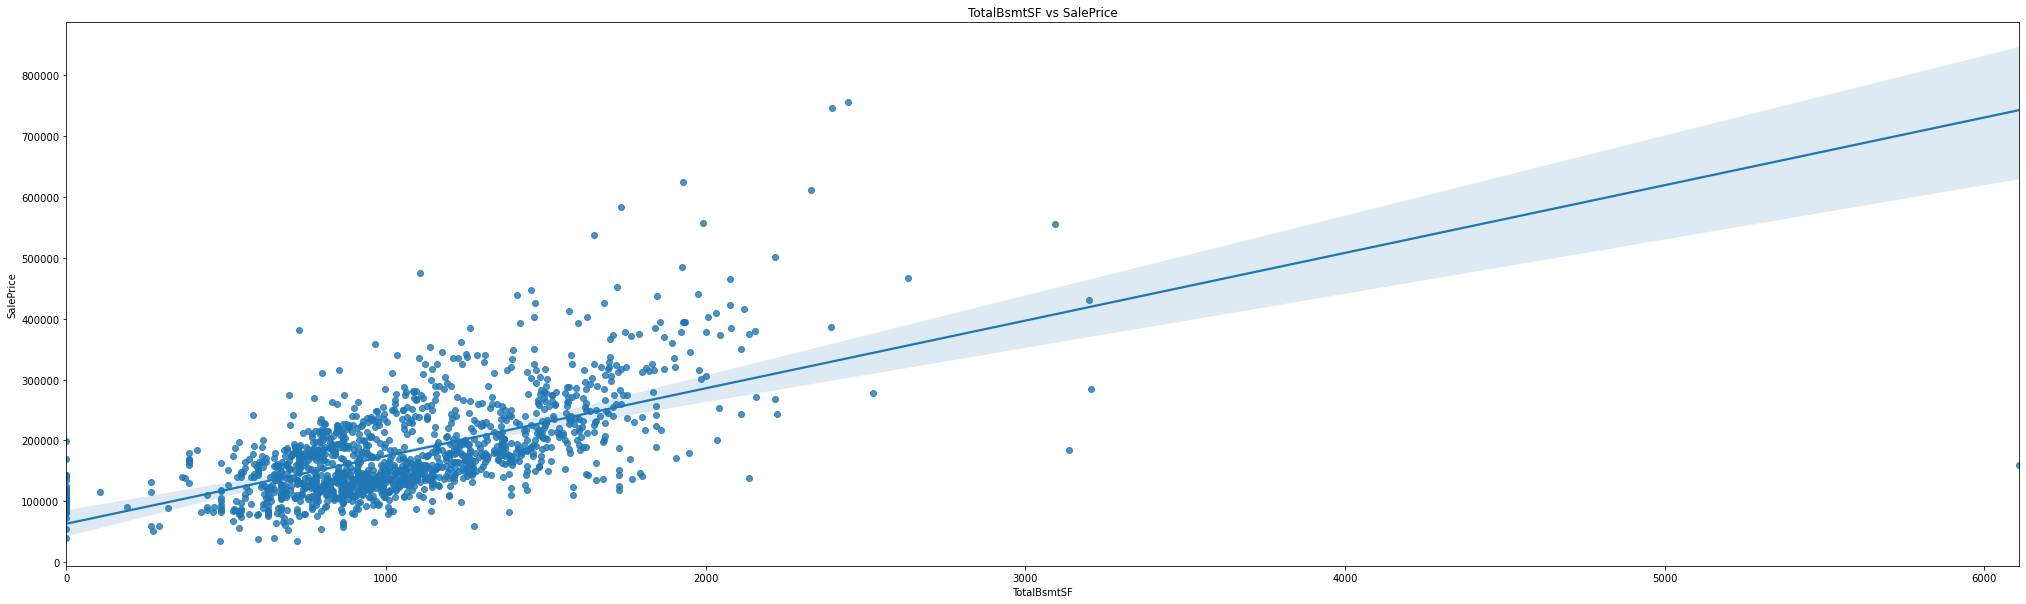

In [21]:
plt.figure(figsize=(35, 10))
plt.title("TotalBsmtSF vs SalePrice")
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train_data)
plt.show()

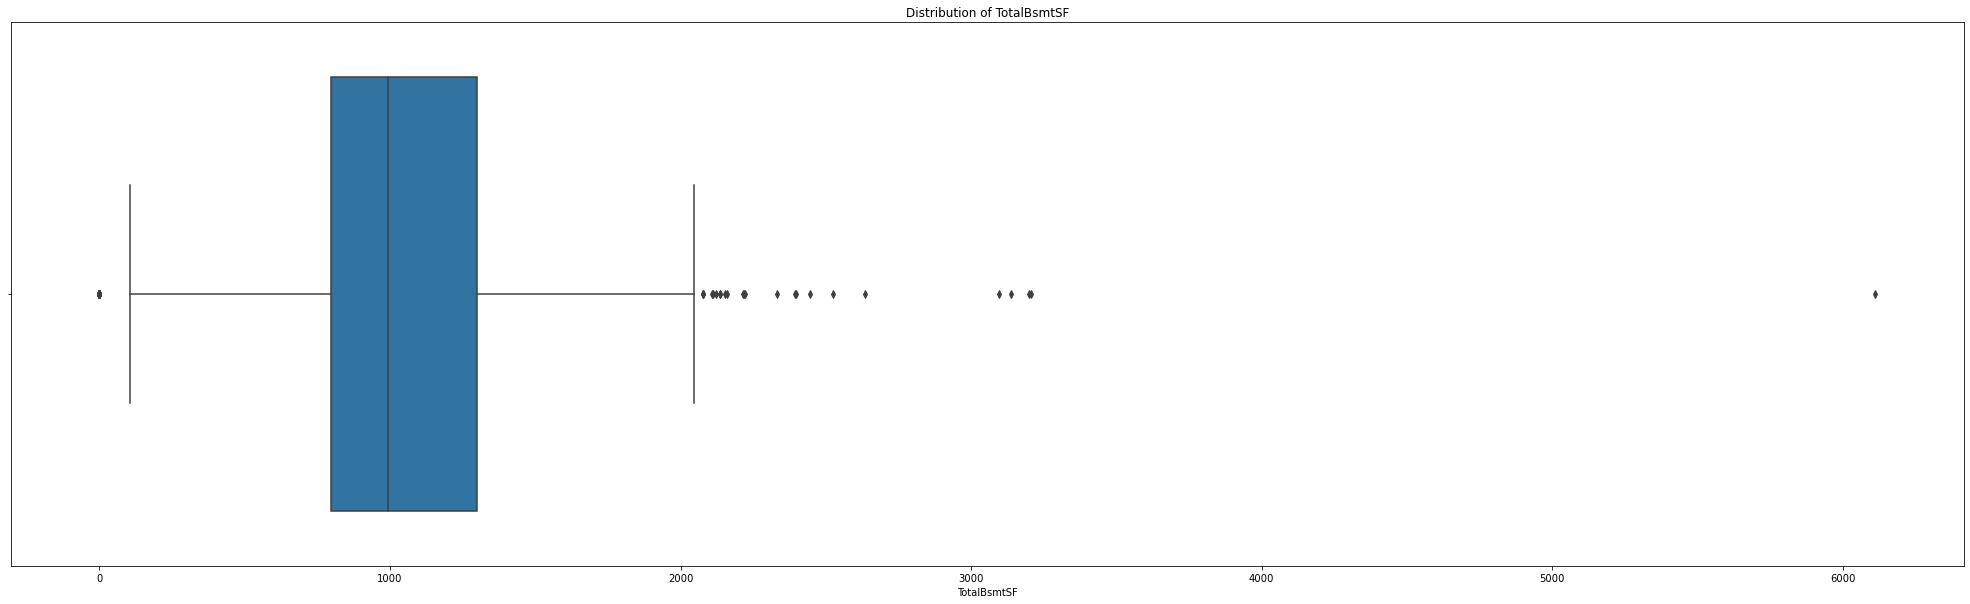

In [22]:
plt.figure(figsize=(35, 10))
plt.title("Distribution of TotalBsmtSF")
sns.boxplot(train_data['TotalBsmtSF'])
plt.show()

In [23]:
Q1 = train_data['TotalBsmtSF'].quantile(0.25)
Q3 = train_data['TotalBsmtSF'].quantile(0.75)
IQR = Q3 - Q1

outliers = train_data.loc[(train_data['TotalBsmtSF'] > (Q3 + 1.75 * IQR)) | (train_data['TotalBsmtSF'] < (Q1 - 1.75 * IQR)), 'TotalBsmtSF']

print("Percent of Outliers: ", outliers.count() / train_data['TotalBsmtSF'].count() * 100)

Percent of Outliers:  0.9589041095890412


In [24]:
train_data.drop(train_data.loc[(train_data['TotalBsmtSF'] > (Q3 + 1.75 * IQR)) | (train_data['TotalBsmtSF'] < (Q1 - 1.75 * IQR))].index, inplace=True)

train_data.shape

(1446, 81)

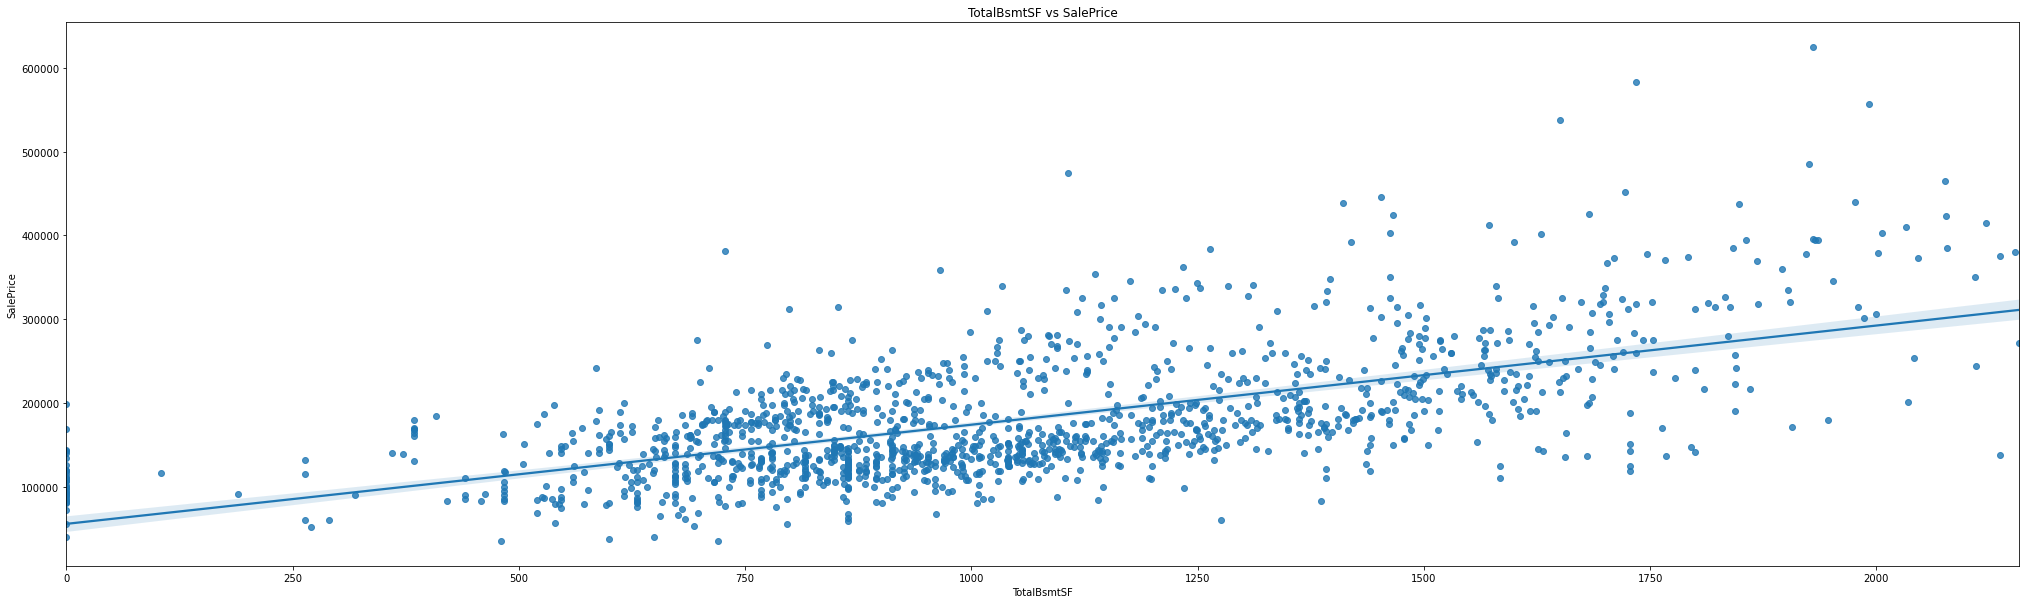

In [25]:
plt.figure(figsize=(35, 10))
plt.title("TotalBsmtSF vs SalePrice")
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train_data)
plt.show()

So TotalBsmtSF is a quantitative variable and contains outliers. Outliers are always bad for predictions, and since there are only 14 outliers in this case, we will just remove all of them.

**1stFlrSF**

In [26]:
train_data['1stFlrSF'].isnull().sum()

0

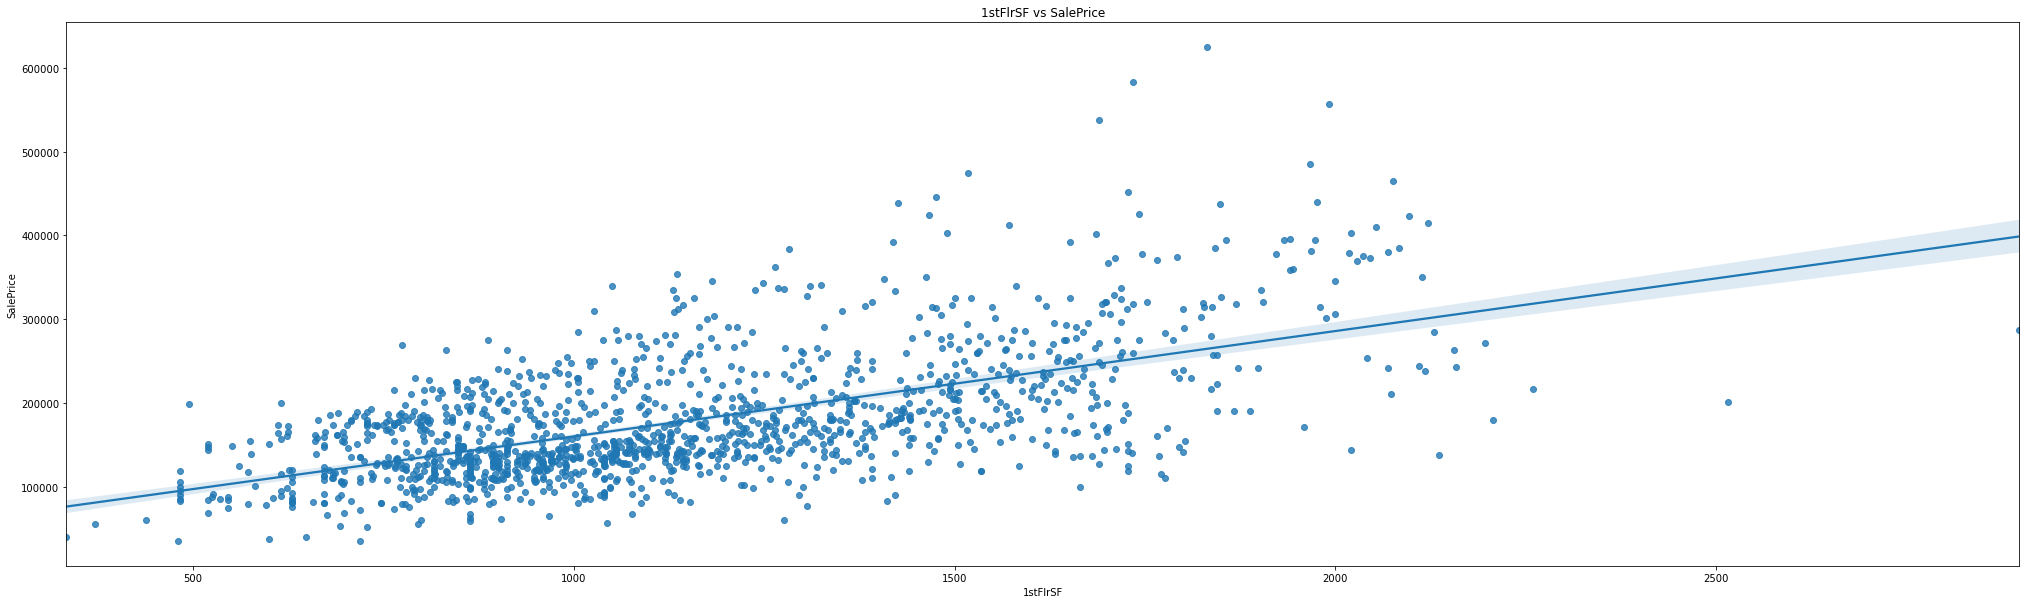

In [27]:
plt.figure(figsize=(35, 10))
plt.title("1stFlrSF vs SalePrice")
sns.regplot(x='1stFlrSF', y='SalePrice', data=train_data)
plt.show()

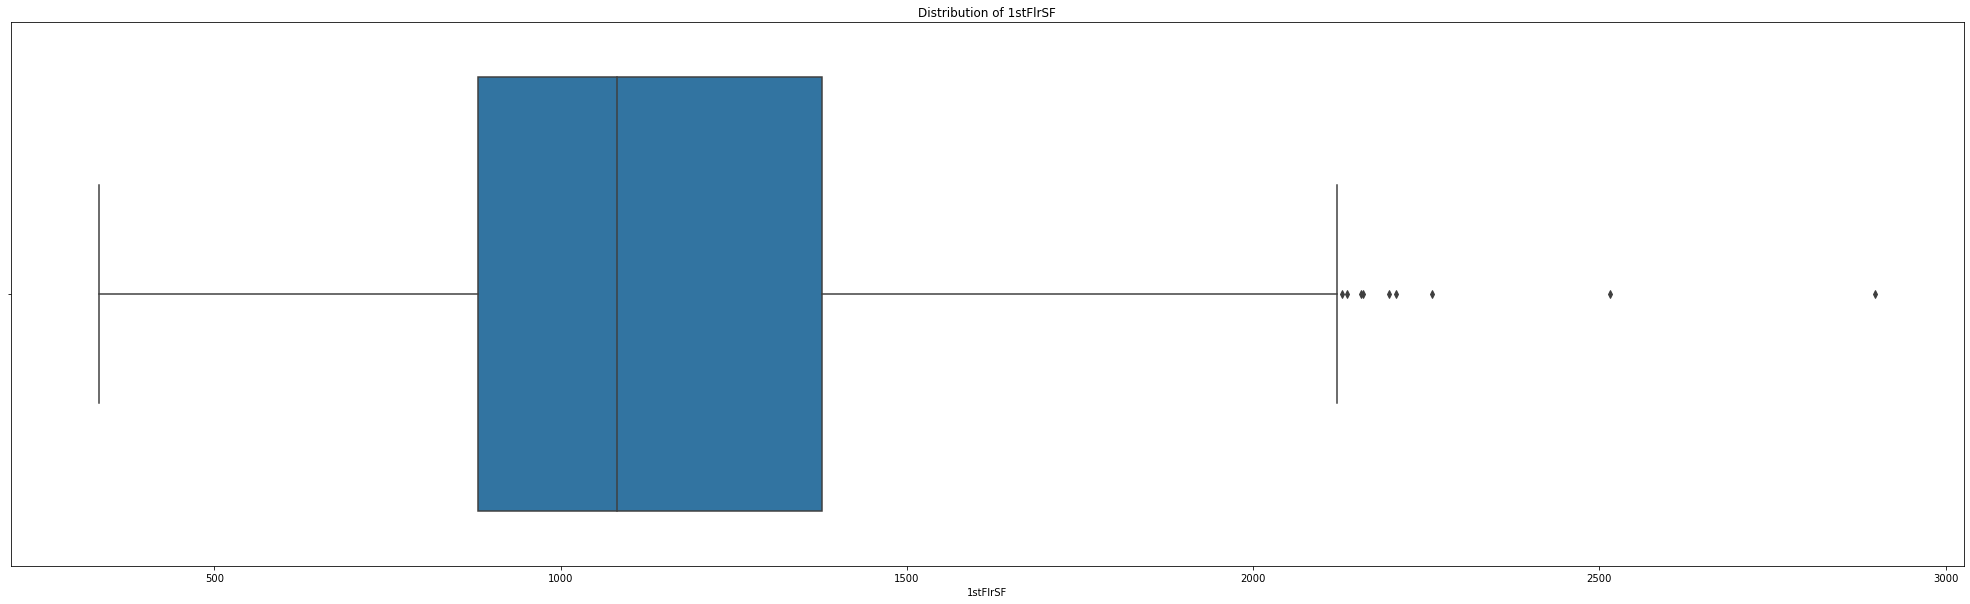

In [28]:
plt.figure(figsize=(35, 10))
plt.title("Distribution of 1stFlrSF")
sns.boxplot(train_data['1stFlrSF'])
plt.show()

In [29]:
Q1 = train_data['1stFlrSF'].quantile(0.25)
Q3 = train_data['1stFlrSF'].quantile(0.75)
IQR = Q3 - Q1

outliers = train_data.loc[(train_data['1stFlrSF'] > (Q3 + 1.75 * IQR)) | (train_data['1stFlrSF'] < (Q1 - 1.75 * IQR)), '1stFlrSF']

print("Percent of Outliers: ", outliers.count() / train_data['1stFlrSF'].count() * 100)

Percent of Outliers:  0.2074688796680498


In [30]:
train_data.drop(train_data.loc[(train_data['1stFlrSF'] > (Q3 + 1.75 * IQR)) | (train_data['1stFlrSF'] < (Q1 - 1.75 * IQR))].index, inplace=True)

train_data.shape

(1443, 81)

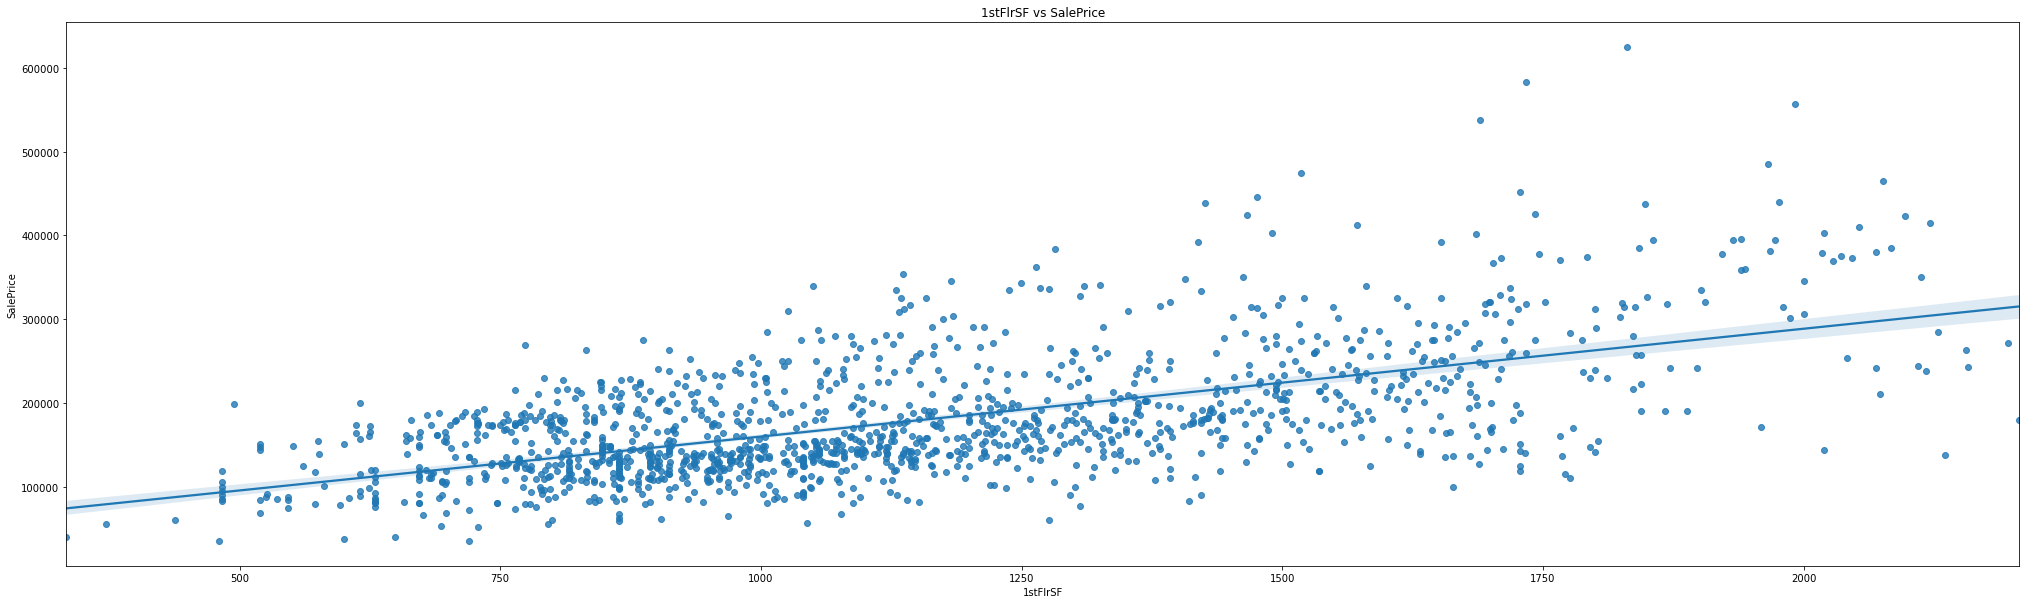

In [31]:
plt.figure(figsize=(35, 10))
plt.title("1stFlrSF vs SalePrice")
sns.regplot(x='1stFlrSF', y='SalePrice', data=train_data)
plt.show()

So TotalBsmtSF is a quantitative variable and contains outliers. Outliers are always bad for predictions, and since there are only 14 outliers in this case, we will just remove all of them.

**GrLivArea**

In [32]:
train_data['GrLivArea'].isnull().sum()

0

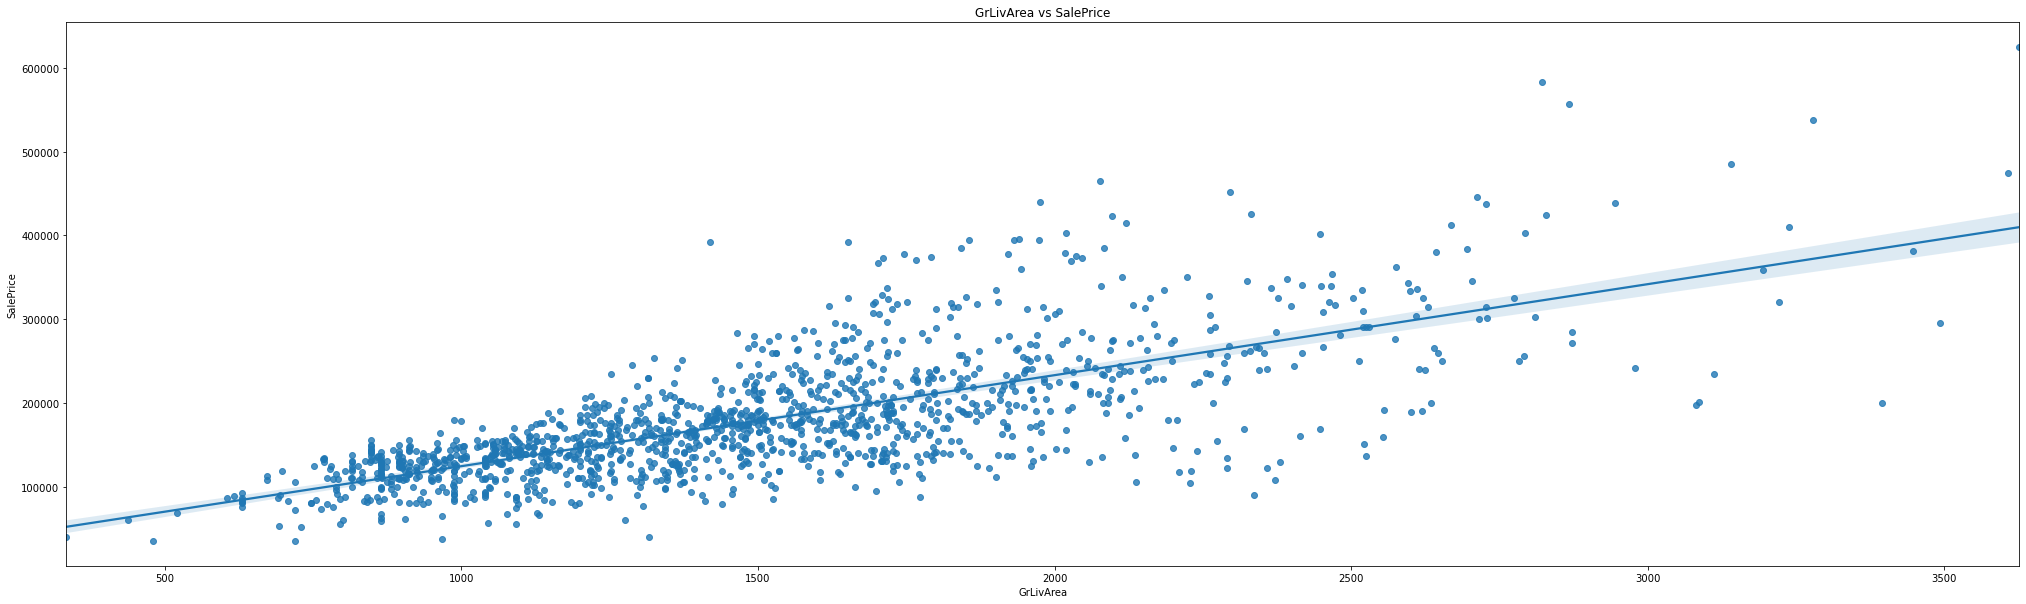

In [33]:
plt.figure(figsize=(35, 10))
plt.title("GrLivArea vs SalePrice")
sns.regplot(x='GrLivArea', y='SalePrice', data=train_data)
plt.show()

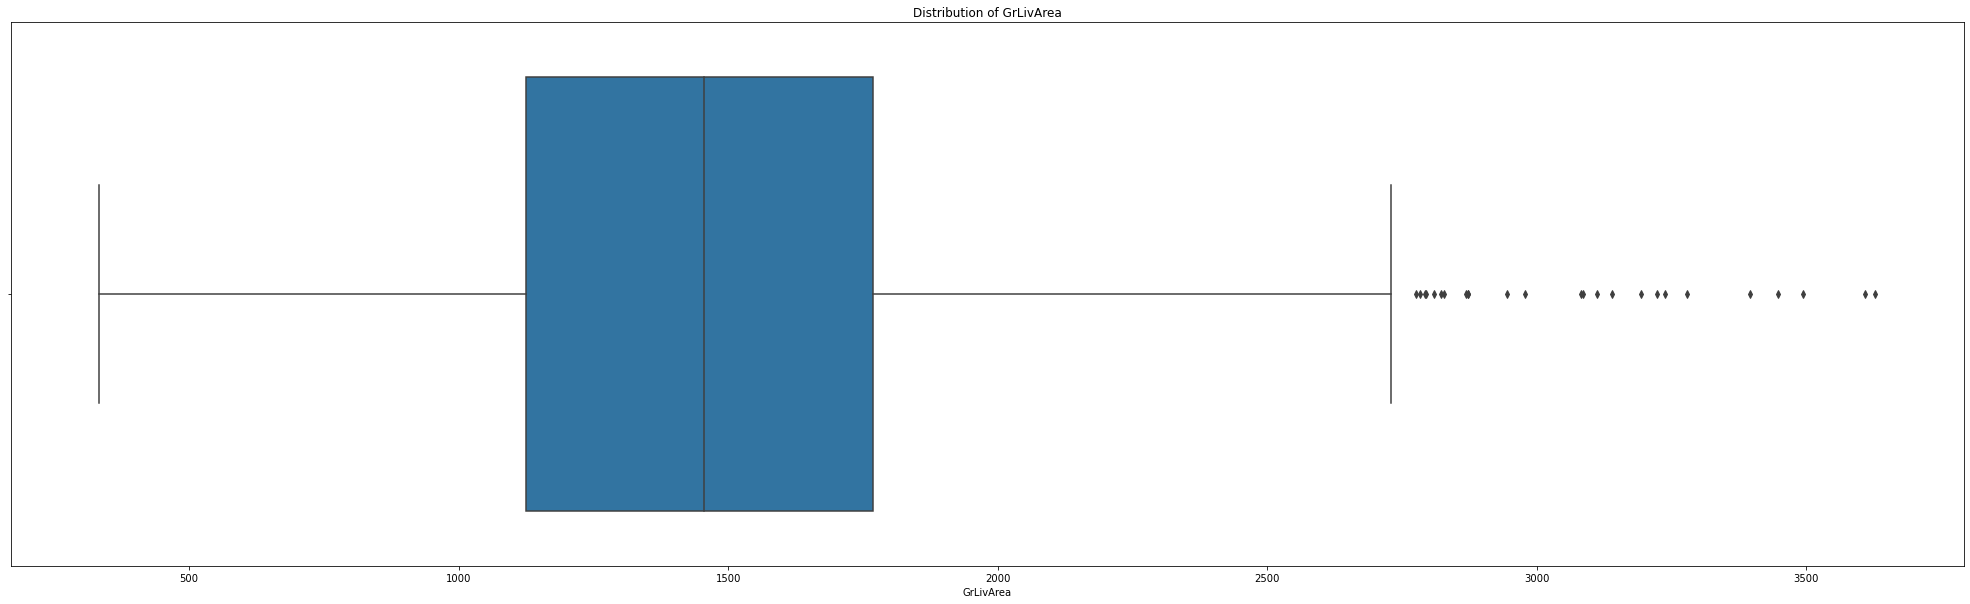

In [34]:
plt.figure(figsize=(35, 10))
plt.title("Distribution of GrLivArea")
sns.boxplot(train_data['GrLivArea'])
plt.show()

In [35]:
Q1 = train_data['GrLivArea'].quantile(0.25)
Q3 = train_data['GrLivArea'].quantile(0.75)
IQR = Q3 - Q1

outliers = train_data.loc[(train_data['GrLivArea'] > (Q3 + 1.75 * IQR)) | (train_data['GrLivArea'] < (Q1 - 1.75 * IQR)), 'GrLivArea']

print("Percent of Outliers: ", outliers.count() / train_data['GrLivArea'].count() * 100)

Percent of Outliers:  1.0395010395010396


In [36]:
train_data.drop(train_data.loc[(train_data['GrLivArea'] > (Q3 + 1.75 * IQR)) | (train_data['GrLivArea'] < (Q1 - 1.75 * IQR))].index, inplace=True)

train_data.shape

(1428, 81)

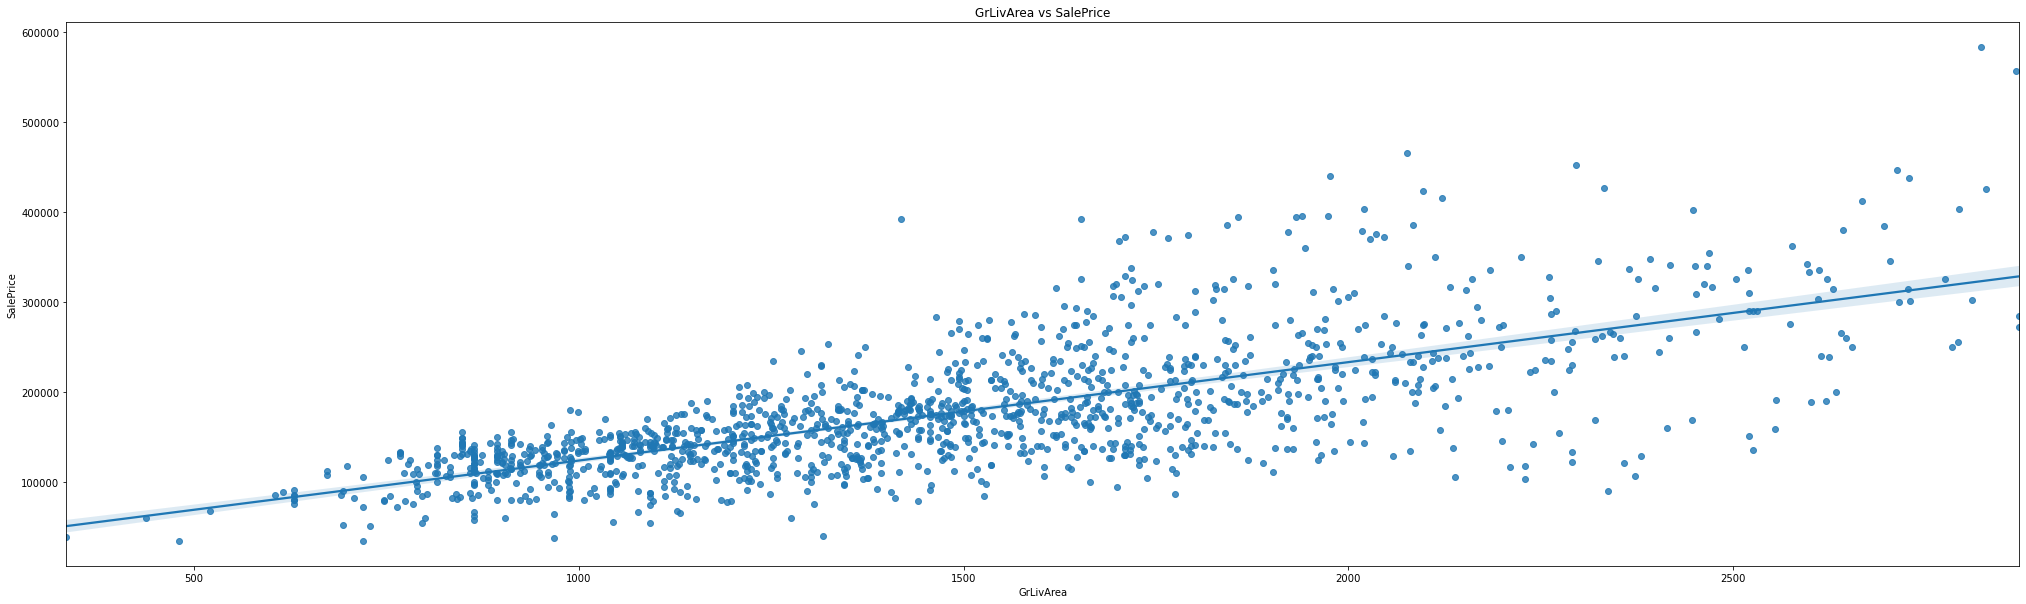

In [37]:
plt.figure(figsize=(35, 10))
plt.title("GrLivArea vs SalePrice")
sns.regplot(x='GrLivArea', y='SalePrice', data=train_data)
plt.show()

So TotalBsmtSF is a quantitative variable and contains outliers. Outliers are always bad for predictions, and since there are only 14 outliers in this case, we will just remove all of them.

**FullBath**

In [38]:
train_data['FullBath'].isnull().sum()

0

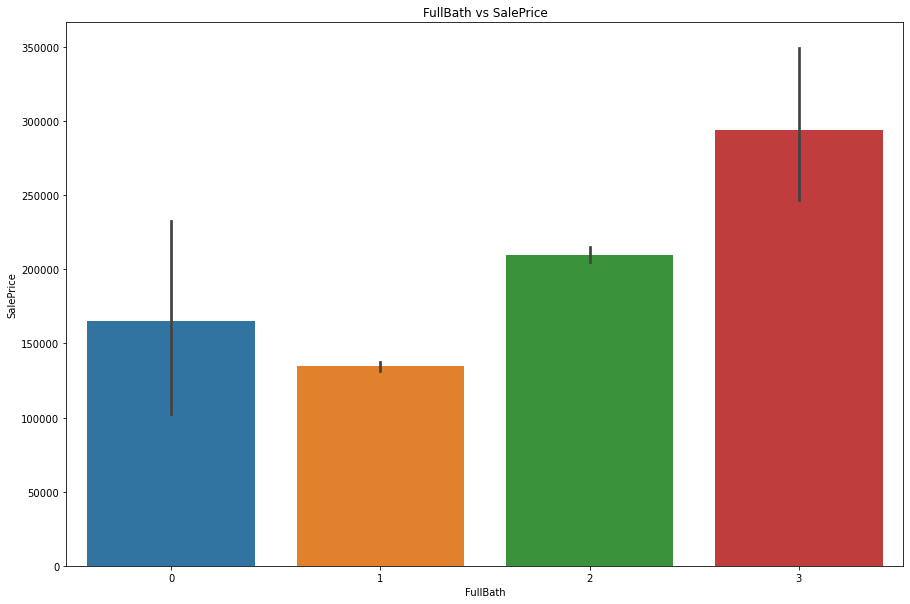

In [39]:
plt.figure(figsize=(15, 10))
plt.title("FullBath vs SalePrice")
sns.barplot(x='FullBath', y='SalePrice', data=train_data)
plt.show()

**TotRmsAbvGrd**

In [40]:
train_data['TotRmsAbvGrd'].isnull().sum()

0

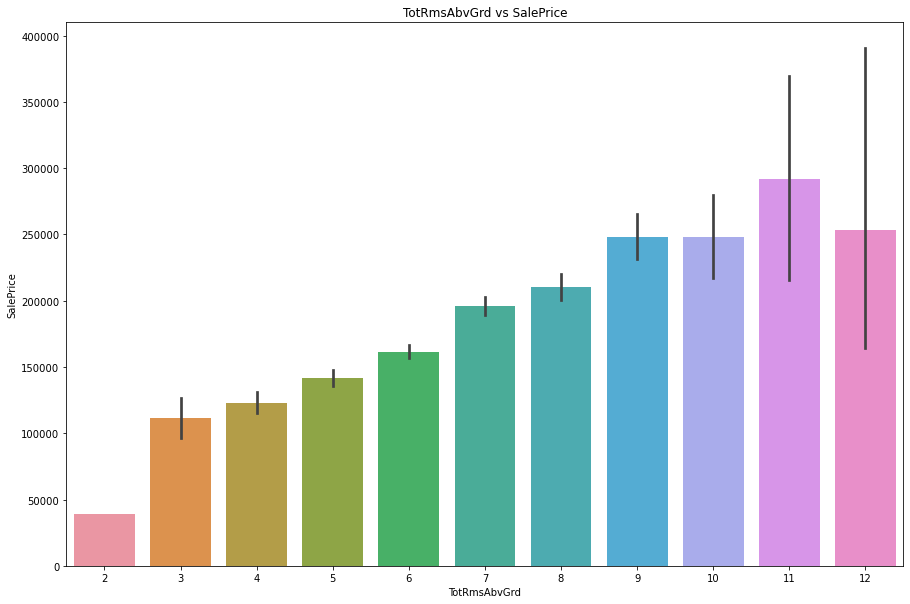

In [41]:
plt.figure(figsize=(15, 10))
plt.title("TotRmsAbvGrd vs SalePrice")
sns.barplot(x='TotRmsAbvGrd', y='SalePrice', data=train_data)
plt.show()

**Garage Cars**

In [42]:
train_data['GarageCars'].isnull().sum()

0

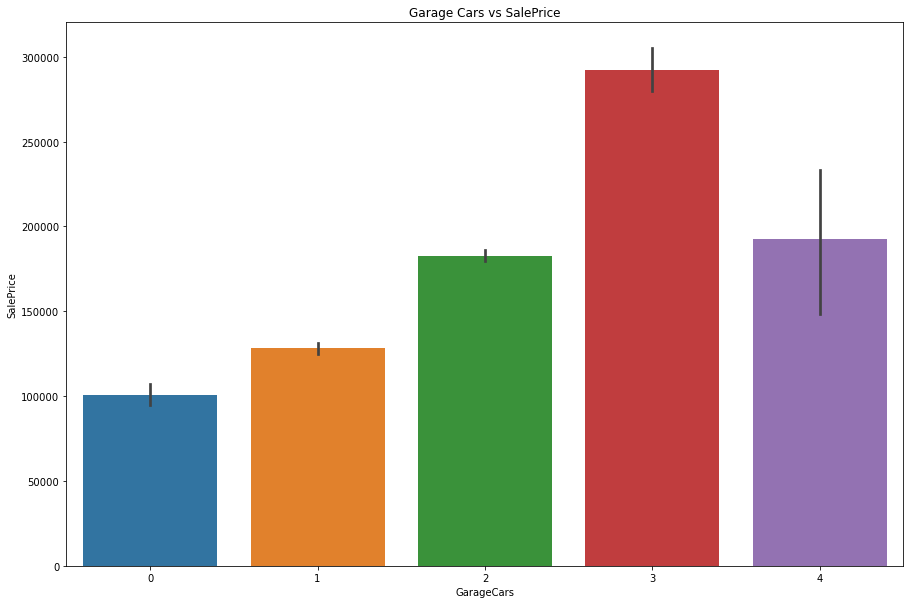

In [43]:
plt.figure(figsize=(15, 10))
plt.title("Garage Cars vs SalePrice")
sns.barplot(x='GarageCars', y='SalePrice', data=train_data)
plt.show()

**GarageArea**

In [44]:
train_data['GarageArea'].isnull().sum()

0

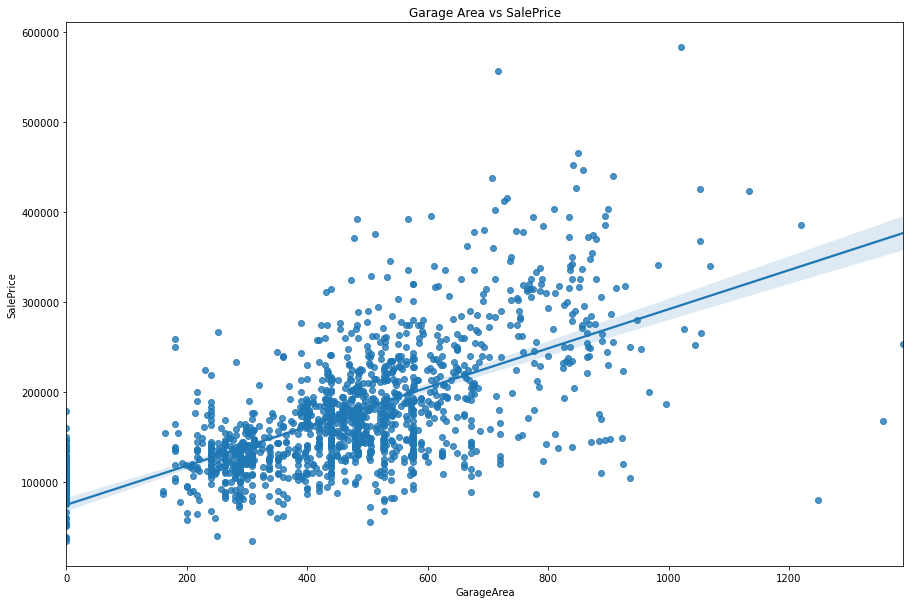

In [45]:
plt.figure(figsize=(15, 10))
plt.title("Garage Area vs SalePrice")
sns.regplot(x='GarageArea', y='SalePrice', data=train_data)
plt.show()

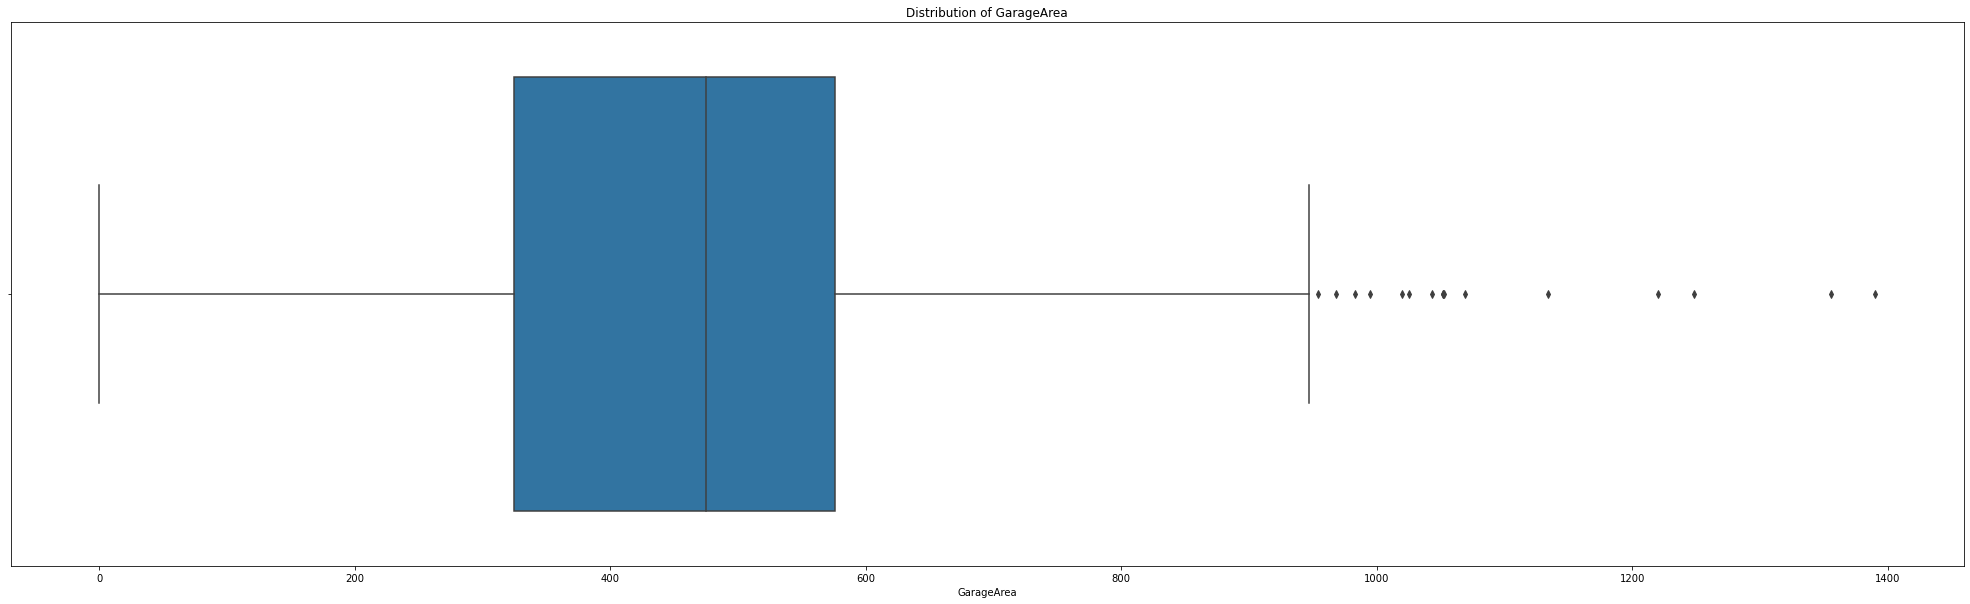

In [46]:
plt.figure(figsize=(35, 10))
plt.title("Distribution of GarageArea")
sns.boxplot(train_data['GarageArea'])
plt.show()

In [47]:
Q1 = train_data['GarageArea'].quantile(0.25)
Q3 = train_data['GarageArea'].quantile(0.75)
IQR = Q3 - Q1

outliers = train_data.loc[(train_data['GarageArea'] > (Q3 + 1.75 * IQR)) | (train_data['GarageArea'] < (Q1 - 1.75 * IQR)), 'GarageArea']

print("Percent of Outliers: ", outliers.count() / train_data['GarageArea'].count() * 100)

Percent of Outliers:  0.8403361344537815


In [48]:
train_data.drop(train_data.loc[(train_data['GarageArea'] > (Q3 + 1.75 * IQR)) | (train_data['GarageArea'] < (Q1 - 1.75 * IQR))].index, inplace=True)

train_data.shape

(1416, 81)

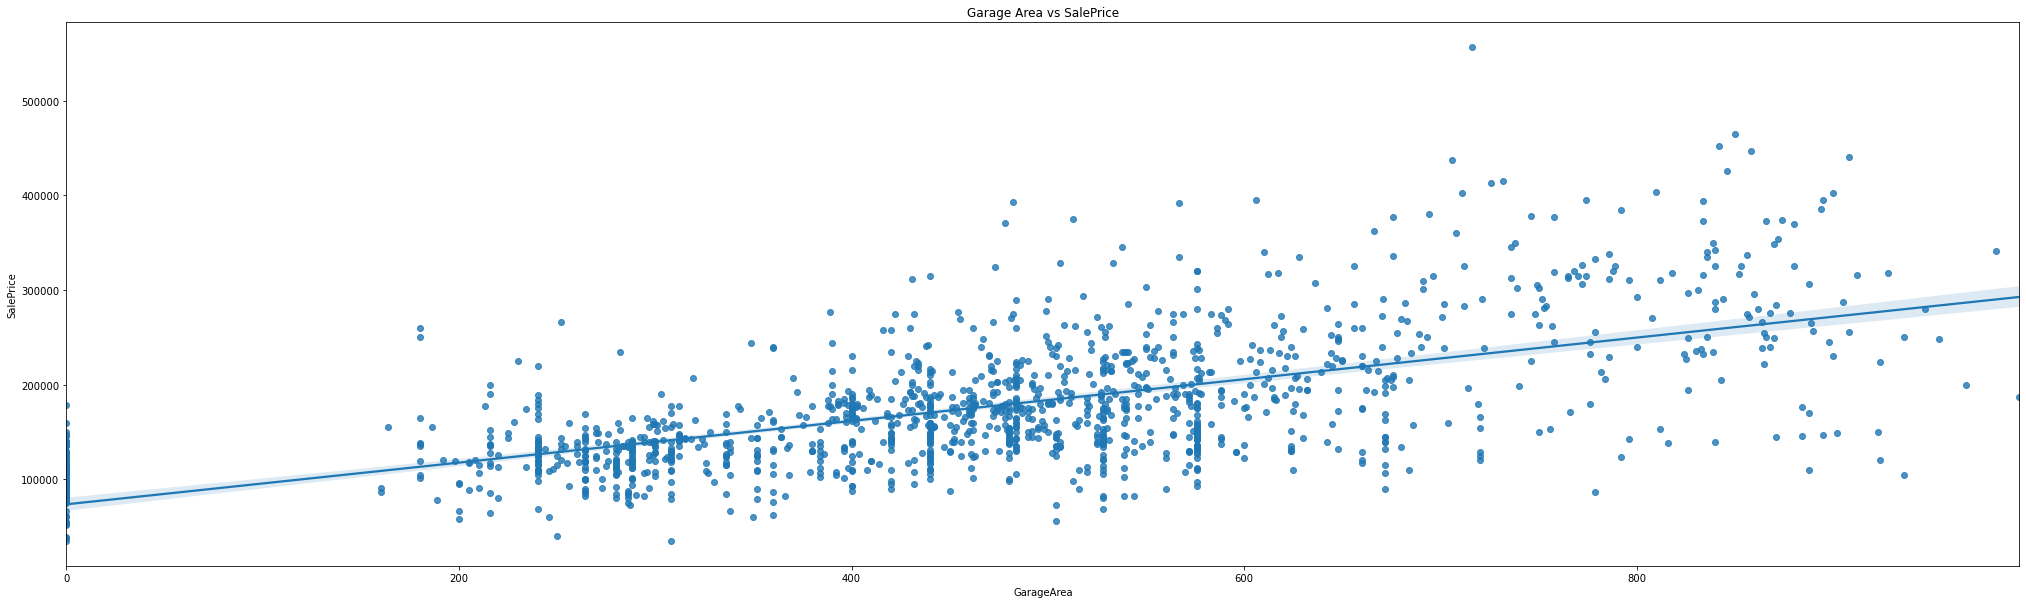

In [49]:
plt.figure(figsize=(35, 10))
plt.title("Garage Area vs SalePrice")
sns.regplot(x='GarageArea', y='SalePrice', data=train_data)
plt.show()

# Hyperparameter Tuning

In this section, we will choose the best parameters for our XGB Regressor. 

In [50]:
'''params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb_model', GridSearchCV(xgb_model, param_grid=params, n_jobs=4, cv=5, verbose=3 ))
                     ])

grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)'''

"params = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 2, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [3, 4, 5]\n        }\n\ngrid = Pipeline(steps=[('preprocessor', preprocessor),\n                      ('xgb_model', GridSearchCV(xgb_model, param_grid=params, n_jobs=4, cv=5, verbose=3 ))\n                     ])\n\ngrid.fit(X_train, y_train)\nprint('\n All results:')\nprint(grid.cv_results_)\nprint('\n Best estimator:')\nprint(grid.best_estimator_)\nprint('\n Best score:')\nprint(grid.best_score_ * 2 - 1)\nprint('\n Best parameters:')\nprint(grid.best_params_)"

In [51]:
hp_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

hp_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('hp_model', hp_model)
                     ])

hp_clf.fit(X_train, y_train, hp_model__verbose=False)

hp_preds = hp_clf.predict(X_valid)

print('RMSLE:', root_mean_squared_log_error(y_valid, hp_preds))

RMSLE: 0.12773959826001952


# Final Data Modification

Finally, let's create some more parameters and make the predictions

In [52]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data.SalePrice

In [53]:
X.columns.to_list()

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [54]:
X_feat_eng = X.copy()

X_feat_eng['years_since_update'] = X_feat_eng['YearRemodAdd'] - X_feat_eng['YearBuilt']
X_feat_eng['geometry'] = X_feat_eng['LotArea'] / X_feat_eng['LotFrontage']
X_feat_eng['land_topology'] = X_feat_eng['LandSlope'] + '_' + X_feat_eng['LandContour']
X_feat_eng['value_proposition'] = X_feat_eng['YearBuilt'] * X_feat_eng['OverallQual']
X_feat_eng['finished_basement'] = X_feat_eng['BsmtFinSF1'] > 0
X_feat_eng['garage_value'] = X_feat_eng['YearBuilt'] * X_feat_eng['GarageCars']
X_feat_eng['misc_value'] = X_feat_eng['Fireplaces'] + X_feat_eng['OverallQual']  
X_feat_eng = X_feat_eng.drop(columns=['GarageCars'])
X_feat_eng['Test'] = X_feat_eng['Street'] + '_' + X_feat_eng['Alley']

feature_numerical_cols = [cname for cname in X_feat_eng.columns if 
                X_feat_eng[cname].dtype in ['int64', 'float64']]

feature_categorical_cols = [cname for cname in X_feat_eng.columns if X_feat_eng[cname].nunique() < 50 
                            and X_feat_eng[cname].dtype in ['object', 'bool']]

feature_numerical_transformer = SimpleImputer(strategy='constant')

feature_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', feature_numerical_transformer, feature_numerical_cols),
        ('cat', feature_categorical_transformer, feature_categorical_cols)
])

feature_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0, monotone_constraints='()',
             n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

feature_clf = Pipeline(steps=[('feature_preprocessor', feature_preprocessor),
                      ('feature_model', feature_model)
                     ])

feature_X_train, feature_X_valid, feature_y_train, feature_y_valid = train_test_split(X_feat_eng, y, random_state=0)

feature_clf.fit(feature_X_train, feature_y_train, feature_model__verbose=False) 
feature_preds = feature_clf.predict(feature_X_valid)

print('RMSLE:', root_mean_squared_log_error(feature_y_valid, feature_preds))

RMSLE: 0.10929809089480493


# Prediction

In [55]:
X_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [56]:
X_test['years_since_update'] = X_test['YearRemodAdd'] - X_test['YearBuilt']
X_test['geometry'] = X_test['LotArea'] / X_test['LotFrontage']
X_test['land_topology'] = X_test['LandSlope'] + '_' + X_test['LandContour']
X_test['value_proposition'] = X_test['YearBuilt'] * X_test['OverallQual']
X_test['finished_basement'] = X_test['BsmtFinSF1'] > 0
X_test['garage_value'] = X_test['YearBuilt'] * X_test['GarageCars']
X_test['misc_value'] = X_test['Fireplaces'] + X_test['OverallQual']
X_test['Test'] = X_test['Street'] + '_' + X_test['Alley']

X_test = X_test.drop(columns=['GarageCars'])

feature_clf.fit(X_feat_eng, y, feature_model__verbose=False)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalf...
                              colsample_bytree=0.

In [57]:
preds = feature_clf.predict(X_test)
output = pd.DataFrame({'Id': X_test.Id,
                       'SalePrice': preds})
output.to_csv('submission.csv', index=False)